<a href="https://colab.research.google.com/github/Shra1-25/ML4SCI/blob/main/ParticleImages/ParticleImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon - Particle Images
## Problem Statement

*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.



## Create the appropriate project folder 

In [2]:
mkdir Particle_Images

In [3]:
cd Particle_Images

/content/Particle_Images


In [4]:
mkdir data/

# Download the Dataset

In [5]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2020-10-12 09:26:02--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.38, 137.138.120.151, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  4.12MB/s    in 18s     

Last-modified header invalid -- time-stamp ignored.
2020-10-12 09:26:24 (4.69 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2020-10-12 09:26:24--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 128.142.32.38, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (76

# Import modules

In [6]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Keras Model Parameters

In [7]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [8]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
## Two classes of particles: electrons and photons
## 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [9]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [10]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys


# Plot sample of training images

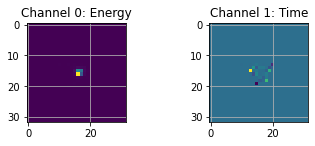

In [11]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [12]:
### Define Convolutional Neural Network (CNN) Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

## Train the Model
### You may optimize the model, tune hyper-parameters, etc. accordingly.

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/20
32/32 [==============================] - 1s 18ms/step - loss: 0.6933 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.5415 - val_loss: 0.6857 - val_accuracy: 0.5664
Epoch 4/20
32/32 [==============================] - 0s 11ms/step - loss: 0.6801 - accuracy: 0.5679 - val_loss: 0.6835 - val_accuracy: 0.5542
Epoch 5/20
32/32 [==============================] - 0s 10ms/step - loss: 0.6722 - accuracy: 0.5840 - val_loss: 0.6793 - val_accuracy: 0.5757
Epoch 6/20
32/32 [==============================] - 0s 11ms/step - loss: 0.6669 - accuracy: 0.5977 - val_loss: 0.6814 - val_accuracy: 0.5796
Epoch 7/20
32/32 [==============================] - 0s 11ms/step - loss: 0.6566 - accuracy: 0.6069 - val_loss: 0.6718 - val_accuracy: 0.5879
Epoch 8/20
32

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [14]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

64/64 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5869

Validation loss / accuracy: 0.6850 / 0.5869
Validation ROC AUC: 0.6159896850585938
64/64 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5942

Test loss / accuracy: 0.6861 / 0.5942
Test ROC AUC: 0.6193246841430664


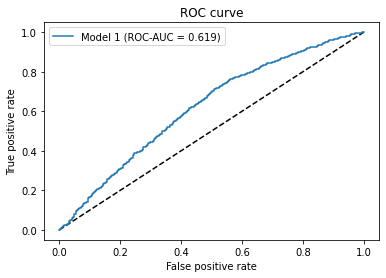

In [15]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Submission format: 
## Please the Google Colab Jupyter Notebook demonstrating your solution in the similar format as in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.